# TEAM 3 | Project Week 3

## Installing

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 489.6 MB 15 kB/s 


In [2]:
!pip install -q keras

## Import

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import cv2
import os
import shutil

In [22]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPool2D, Dropout, LSTM, Embedding, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob

# The Data

In this project, we want to classify data based on bio-medical (microscopy) images, namely breast 
cancer histopathology images.  

The entire dataset contains 7909 images of breast tumor tissue with different magnifying factors. 
However, you can restrict yourselves to use only one magnifying factor, e.g. 400X. You can also 
ignore the additional cancer types and focus on the labels “benign” vs “malignant”. 

In [10]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/My\ Drive/archive.zip

#!unzip archive.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-026.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-027.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-028.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-029.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-030.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-031.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/ma

Get data for magnifying factor 100X

In [11]:
data = pd.read_csv('Folds.csv')

data = data.rename(columns={'filename':'path'})
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data['label'] = data.path.apply(lambda x: x.split('/')[3])

data.head()

,fold,mag,grp,path,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-004.png,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-005.png,benign


In [12]:
data = data.loc[data['mag'] == 100]
data.head()

,fold,mag,grp,path,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-004.png,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-005.png,benign


Preprocess images

In [13]:
os.mkdir('/content/BreaKHis_v1/augmented')
os.mkdir('/content/BreaKHis_v1/augmented/benign')
os.mkdir('/content/BreaKHis_v1/augmented/malignant')

ben_path = '/content/BreaKHis_v1/augmented/benign/'
mal_path = '/content/BreaKHis_v1/augmented/malignant/'

for _, row in data.iterrows():
    path = row['path']
    filename = row['filename']
    if row['label'] == 'benign':
      shutil.copyfile('/content/BreaKHis_v1/' + path, ben_path + filename)
    elif row['label'] == 'malignant':
      shutil.copyfile('/content/BreaKHis_v1/' + path, mal_path + filename)

In [14]:
def preprocessing(img_path, img):
    image = cv2.imread(img_path + img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    image = cv2.medianBlur(image, 5)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    cv2.imwrite(img_path + img, image)

In [15]:
for image in os.listdir(ben_path):
    image = preprocessing(ben_path, image)

for image in os.listdir(mal_path):
    image = preprocessing(mal_path, image)

Generate a Training set and a Validation set

In [125]:
ig = ImageDataGenerator(validation_split=0.2, rescale=1/255)

In [126]:
aug_path = '/content/BreaKHis_v1/augmented/'
classes = ['benign', 'malignant']

train_batches = ig.flow_from_directory(directory = aug_path,
                                       target_size = (224,224),
                                       classes = classes,
                                       class_mode='binary',
                                       batch_size = 16,
                                       subset = 'training')

valid_batches = ig.flow_from_directory(directory = aug_path,
                                       target_size = (224,224),
                                       classes = classes,
                                       class_mode='binary',
                                       batch_size = 16,
                                       subset = 'validation')

Found 1666 images belonging to 2 classes.
Found 415 images belonging to 2 classes.


# The Task: Deep Learning for image classification

Your task is to develop (or: train) Deep Learning based classifiers that works directly on the images.

You should try three different Deep Learning (DL) topologies which need to be described in detail 
(and compared!) in the results section and to perform an evaluation using the appropriate 
techniques. One of the three DL topologies needs to be a CNN. One does not have to be “deep”, i.e. 
can have only few layers, e.g. a fully connected NN with 2 hidden layers. 

## **RNN USING LSTM**

In [127]:
rnn = Sequential()
#rnn.add(Embedding(input_dim=224, output_dim=2))
rnn.add(Reshape((-1, 224*3), input_shape=(224,224,3)))

rnn.add(LSTM(128, activation='tanh', return_sequences=True))
#rnn.add(ConvLSTM2D(filters=20,kernel_size=(3,3),input_shape=(100,224,224,3),
#                   padding="same",return_sequences=True, data_format="channels_last"))
rnn.add(Dropout(0.4))

rnn.add(LSTM(128, activation='tanh', return_sequences=False))
rnn.add(Dropout(0.2))

rnn.add(Dense(2, activation='relu'))
rnn.add(Dropout(0.4))

rnn.add(Dense(1, activation='sigmoid'))

In [128]:
rnn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_15 (Reshape)        (None, 224, 672)          0         
                                                                 
 lstm_32 (LSTM)              (None, 224, 128)          410112    
                                                                 
 dropout_50 (Dropout)        (None, 224, 128)          0         
                                                                 
 lstm_33 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 2)                 258       
                                                                 
 dropout_52 (Dropout)        (None, 2)               

In [129]:
rnn_opt = optimizers.Adam(learning_rate=0.0001)
rnn_loss = losses.binary_crossentropy

In [130]:
rnn.compile(optimizer = rnn_opt, 
            loss = rnn_loss,
            metrics = ['accuracy'])

In [140]:
#next(train_batches)


In [132]:
rnn_history = rnn.fit(x = train_batches,
                      steps_per_epoch = len(train_batches),
                      validation_data = valid_batches,
                      validation_steps = len(valid_batches),
                      epochs = 5)


Epoch 1/5
105/105 [==============================] - 110s 678ms/step - loss: 0.6252 - accuracy: 0.6861 - val_loss: 0.5985 - val_accuracy: 0.6916
Epoch 2/5
105/105 [==============================] - 71s 672ms/step - loss: 0.6119 - accuracy: 0.6903 - val_loss: 0.6100 - val_accuracy: 0.6916
Epoch 3/5
105/105 [==============================] - 70s 670ms/step - loss: 0.6056 - accuracy: 0.6903 - val_loss: 0.5987 - val_accuracy: 0.6916
Epoch 4/5
105/105 [==============================] - 70s 671ms/step - loss: 0.5934 - accuracy: 0.6903 - val_loss: 0.5753 - val_accuracy: 0.6916
Epoch 5/5
105/105 [==============================] - 71s 671ms/step - loss: 0.5695 - accuracy: 0.6903 - val_loss: 0.5369 - val_accuracy: 0.6916


### **MLP**

In [133]:
# Develop a sequential model using tensorflow keras
mlp = Sequential()
mlp.add(Flatten(input_shape=(224,224,3)))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

In [134]:
mlp.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense_43 (Dense)            (None, 256)               38535424  
                                                                 
 dense_44 (Dense)            (None, 1)                 257       
                                                                 
Total params: 38,535,681
Trainable params: 38,535,681
Non-trainable params: 0
_________________________________________________________________


In [135]:
mlp_loss = losses.binary_crossentropy

In [136]:
# Compute the model parameters
mlp.compile(optimizer = opt, 
            loss = mlp_loss,
            metrics = ['accuracy'])

In [137]:
mlp_history = mlp.fit(x = train_batches,
                      steps_per_epoch = len(train_batches),
                      validation_data = valid_batches,
                      validation_steps = len(valid_batches),
                      epochs = 5)

Epoch 1/5
105/105 [==============================] - 24s 227ms/step - loss: 5.7038 - accuracy: 0.6753 - val_loss: 3.9903 - val_accuracy: 0.5398
Epoch 2/5
105/105 [==============================] - 24s 226ms/step - loss: 2.0311 - accuracy: 0.7707 - val_loss: 7.7473 - val_accuracy: 0.4313
Epoch 3/5
105/105 [==============================] - 24s 225ms/step - loss: 1.5173 - accuracy: 0.8169 - val_loss: 1.8592 - val_accuracy: 0.6867
Epoch 4/5
105/105 [==============================] - 24s 226ms/step - loss: 1.4333 - accuracy: 0.8043 - val_loss: 1.7027 - val_accuracy: 0.6723
Epoch 5/5
105/105 [==============================] - 24s 225ms/step - loss: 1.1757 - accuracy: 0.8403 - val_loss: 6.8720 - val_accuracy: 0.4313


### **CNN**

In [147]:
cnn = Sequential()
cnn.add(Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
cnn.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
cnn.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
cnn.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.4))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.4))
cnn.add(Dense(1, activation='sigmoid'))

In [148]:
cnn.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                

In [151]:
cnn_loss = losses.binary_crossentropy
cnn.compile(optimizer = opt, 
            loss = cnn_loss,
            metrics = ['accuracy'])

In [153]:
cnn_history = cnn.fit(x = train_batches,
                      steps_per_epoch = len(train_batches),
                      validation_data = valid_batches,
                      validation_steps = len(valid_batches),
                      epochs = 5)

Epoch 1/5
105/105 [==============================] - 562s 5s/step - loss: 0.6169 - accuracy: 0.6615 - val_loss: 0.5774 - val_accuracy: 0.6916
Epoch 2/5
105/105 [==============================] - 560s 5s/step - loss: 0.5339 - accuracy: 0.6843 - val_loss: 0.5284 - val_accuracy: 0.6916
Epoch 3/5
105/105 [==============================] - 560s 5s/step - loss: 0.5166 - accuracy: 0.6891 - val_loss: 0.5361 - val_accuracy: 0.6916
Epoch 4/5
105/105 [==============================] - 558s 5s/step - loss: 0.5057 - accuracy: 0.7113 - val_loss: 0.5165 - val_accuracy: 0.6940
Epoch 5/5
105/105 [==============================] - 558s 5s/step - loss: 0.5066 - accuracy: 0.7293 - val_loss: 0.5087 - val_accuracy: 0.7012


## Evaluation

In [181]:
def plot_result2(history, deepnet):
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)
    fig, axs = plt.subplots(1,2)
    axs[0].plot(epochs, train_acc, 'bo-')
    axs[0].plot(epochs, val_acc, 'go-')
    axs[0].set_ylabel("Accuracy")

    axs[1].plot(epochs, train_loss, 'bo-')
    axs[1].plot(epochs, val_loss, 'go-')
    axs[1].set_ylabel("Loss")
    fig.tight_layout(rect =[0, 0.03, 1, 0.95])
    fig.suptitle('Training and validation ' + deepnet)
    #fig.xlabel("Epochs")
    fig.legend(["train", 'val'])
    plt.show()

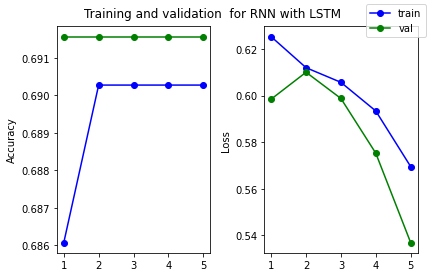

In [180]:
plot_result2(rnn_history, ' for RNN with LSTM')

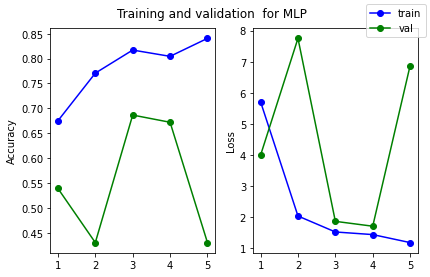

In [182]:
plot_result2(mlp_history, ' for MLP')

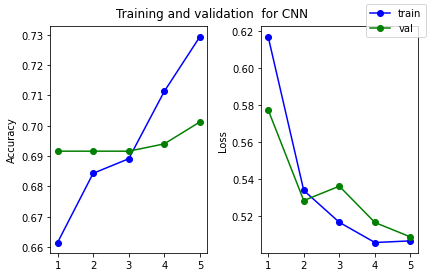

In [183]:
plot_result2(cnn_history, ' for CNN')

**SOM- Self Organizing Map**